# Titanic Survival Prediction: Full Data Science Lifecycle

This notebook follows a clear DS workflow:

1. Setup & Configuration
2. Data Loading
3. Data Cleaning
4. Exploratory Data Analysis (EDA)
5. Feature Engineering
6. Train/Validation/Test Split
7. Preprocessing + Model Pipeline (Logistic Regression)
8. Baseline CV and Test Evaluation
9. Hyperparameter Tuning (GridSearchCV)
10. Final Test Evaluation, Diagnostics
11. Save Artifacts
12. Inference Example



In [41]:
# Setup & Configuration

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display options
pd.set_option("display.max_columns", 100)
plt.style.use("seaborn-v0_8-whitegrid")

print("Versions -> pandas:", pd.__version__, "| numpy:", np.__version__)
try:
    import sklearn
    print("scikit-learn:", sklearn.__version__)
except Exception:
    pass


Versions -> pandas: 2.3.3 | numpy: 2.4.0
scikit-learn: 1.8.0


In [42]:
# Data Loading


TARGET = "survived"

# Try seaborn's titanic dataset, fallback to local CSV (train.csv)
raw_df = None
try:
    raw_df = sns.load_dataset("titanic")
    print("Loaded seaborn titanic dataset.")
except Exception as e:
    print("Seaborn dataset load failed:", e)

if raw_df is None:
    candidates = [Path("train.csv"), Path("data/train.csv"), Path("dataset/train.csv")] 
    for p in candidates:
        if p.exists():
            raw_df = pd.read_csv(p)
            print("Loaded local dataset:", p)
            break

if raw_df is None:
    raise FileNotFoundError("Could not load Titanic dataset from seaborn or local files.")

print("Raw dataset shape:", raw_df.shape)
display(raw_df.head())


Loaded seaborn titanic dataset.
Raw dataset shape: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [43]:
# Data Cleaning


cols_to_use = [
    "survived", "pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"
]

df = raw_df.copy()

# Keep only expected columns if present
df = df[[c for c in cols_to_use if c in df.columns]].copy()

# Drop rows without target
if TARGET in df.columns:
    df = df[~df[TARGET].isna()].copy()

# Handle missing values (basic strategy)
if "age" in df.columns:
    df["age"] = df["age"].astype(float)
    df["age"].fillna(df["age"].median(), inplace=True)
if "fare" in df.columns:
    df["fare"] = df["fare"].astype(float)
    df["fare"].fillna(df["fare"].median(), inplace=True)
if "embarked" in df.columns:
    df["embarked"].fillna(df["embarked"].mode().iloc[0], inplace=True)

# Basic plausibility filters
if "age" in df.columns:
    df = df[(df["age"] >= 0) & (df["age"] <= 100)]
if "fare" in df.columns:
    df = df[df["fare"] >= 0]

# Drop duplicates
df = df.drop_duplicates()

print("Cleaned dataset shape:", df.shape)
display(df.head())


Cleaned dataset shape: (775, 8)


,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Target distribution:
 survived
0    0.587097
1    0.412903
Name: fraction, dtype: float64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
survived,775.0,NaN,NaN,NaN,0.412903,0.492674,0.0,0.0,0.0,1.0,1.0
pclass,775.0,NaN,NaN,NaN,2.246452,0.853574,1.0,1.0,3.0,3.0,3.0
sex,775,2,male,483,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,775.0,NaN,NaN,NaN,29.581187,13.766359,0.42,21.0,28.0,36.0,80.0
sibsp,775.0,NaN,NaN,NaN,0.529032,0.990326,0.0,0.0,0.0,1.0,8.0
parch,775.0,NaN,NaN,NaN,0.420645,0.840565,0.0,0.0,0.0,1.0,6.0
fare,775.0,NaN,NaN,NaN,34.878403,52.408474,0.0,8.05,15.9,34.1979,512.3292
embarked,775,3,S,562,NaN,NaN,NaN,NaN,NaN,NaN,NaN


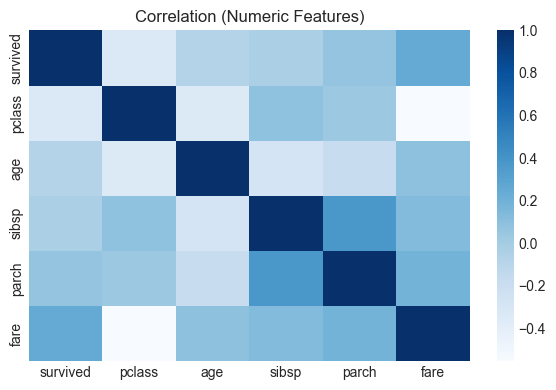

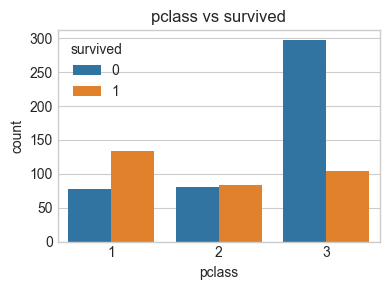

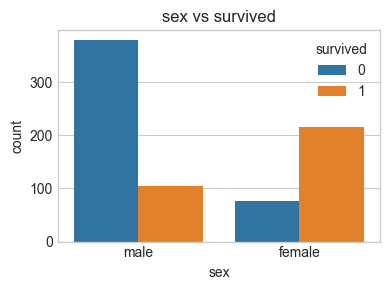

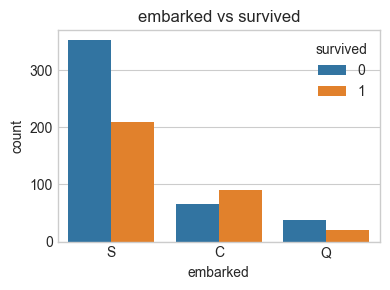

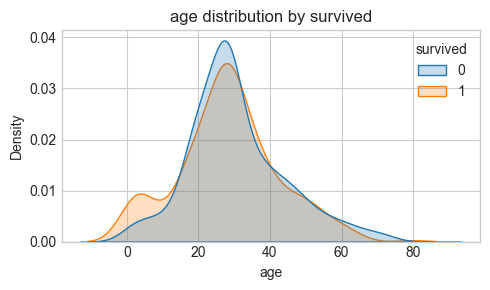

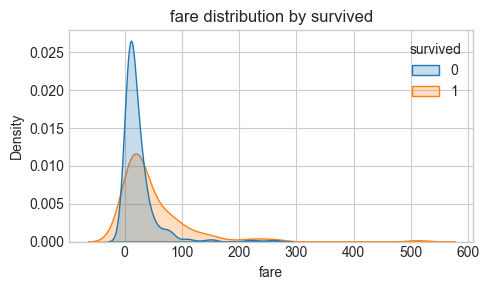

In [44]:
# Exploratory Data Analysis (EDA)


# Target balance
print("Target distribution:\n", df[TARGET].value_counts(normalize=True).rename("fraction"))

# Basic overview
display(df.describe(include="all").transpose())

# Correlations for numeric features
num_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(6,4))
sns.heatmap(df[num_cols].corr(), annot=False, cmap="Blues")
plt.title("Correlation (Numeric Features)")
plt.tight_layout()
plt.show()

# Categorical distributions
cat_cols = df.select_dtypes(include=["category", "object"]).columns
for c in ["pclass", "sex", "embarked"]:
    if c in df.columns:
        plt.figure(figsize=(4,3))
        sns.countplot(data=df, x=c, hue=TARGET)
        plt.title(f"{c} vs {TARGET}")
        plt.tight_layout()
        plt.show()

# Numeric distributions by target
for c in ["age", "fare", "family_size"]:
    if c in df.columns:
        plt.figure(figsize=(5,3))
        sns.kdeplot(data=df, x=c, hue=TARGET, fill=True, common_norm=False)
        plt.title(f"{c} distribution by {TARGET}")
        plt.tight_layout()
        plt.show()


In [45]:
# Feature Engineering


# Family size and isolation feature
if all(col in df.columns for col in ["sibsp", "parch"]):
    df["family_size"] = df["sibsp"].fillna(0) + df["parch"].fillna(0) + 1
    df["is_alone"] = (df["family_size"] == 1).astype(int)
else:
    df["family_size"] = 1
    df["is_alone"] = (df["family_size"] == 1).astype(int)

# Ensure expected categorical types
if "pclass" in df.columns:
    df["pclass"] = df["pclass"].astype("category")
if "sex" in df.columns:
    df["sex"] = df["sex"].astype("category")
if "embarked" in df.columns:
    df["embarked"] = df["embarked"].astype("category")

print("Engineered features added: family_size, is_alone")


Engineered features added: family_size, is_alone


In [46]:
# Train/Validation/Test Split

from sklearn.model_selection import train_test_split

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (620, 9) Test shape: (155, 9)


In [47]:
# Preprocessing and Model Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

numeric_features = ["age", "sibsp", "parch", "fare", "family_size", "is_alone"]
categorical_features = ["pclass", "sex", "embarked"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = LogisticRegression(max_iter=1000, solver="liblinear")

pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", clf)
])

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['age', 'sibsp', 'parch', 'fare', 'family_size', 'is_alone']
Categorical features: ['pclass', 'sex', 'embarked']


In [48]:
# Baseline Training and Cross-Validation

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Evaluate via CV on training data
cv_acc = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
cv_auc = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

print("Baseline CV -> Acc: %.3f ± %.3f | ROC-AUC: %.3f ± %.3f" % (cv_acc.mean(), cv_acc.std(), cv_auc.mean(), cv_auc.std()))

# Fit on train and evaluate on held-out test
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
try:
    auc = roc_auc_score(y_test, y_proba)
except Exception:
    auc = float("nan")

print("Baseline Test -> Acc: %.3f | ROC-AUC: %.3f" % (acc, auc))


Baseline CV -> Acc: 0.776 ± 0.030 | ROC-AUC: 0.834 ± 0.025
Baseline Test -> Acc: 0.781 | ROC-AUC: 0.850


In [49]:
# Hyperparameter Tuning with GridSearchCV

from sklearn.model_selection import GridSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_grid = {
    "model__C": [0.01, 0.1, 1.0, 10.0],
    "model__penalty": ["l1", "l2"],
    "model__solver": ["liblinear"],
    "model__class_weight": [None, "balanced"],
}

scoring = "roc_auc"

grid = GridSearchCV(pipe, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=-1, refit=True, verbose=0)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV %s: %.4f" % (scoring, grid.best_score_))


Best params: {'model__C': 0.1, 'model__class_weight': None, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best CV roc_auc: 0.8395


Test metrics -> Acc: 0.735, Prec: 0.689, Rec: 0.656, F1: 0.672, ROC-AUC: 0.828

              precision    recall  f1-score   support

           0       0.77      0.79      0.78        91
           1       0.69      0.66      0.67        64

    accuracy                           0.74       155
   macro avg       0.73      0.72      0.73       155
weighted avg       0.73      0.74      0.73       155



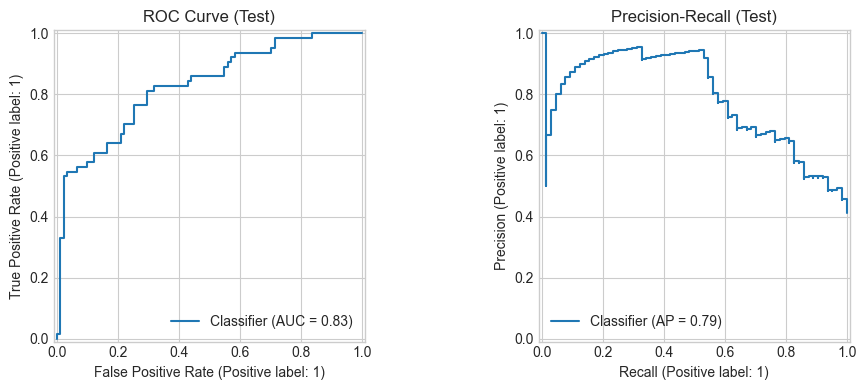

In [50]:
# Final Evaluation on Test Set (Best Model)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, classification_report
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

best_model = grid.best_estimator_

y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, y_test_pred)
pr, rc, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average="binary")
try:
    test_auc = roc_auc_score(y_test, y_test_proba)
except Exception:
    test_auc = float("nan")

print("Test metrics -> Acc: %.3f, Prec: %.3f, Rec: %.3f, F1: %.3f, ROC-AUC: %.3f" % (test_acc, pr, rc, f1, test_auc))
print()
print(classification_report(y_test, y_test_pred))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
RocCurveDisplay.from_predictions(y_test, y_test_proba, ax=ax[0])
ax[0].set_title("ROC Curve (Test)")
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba, ax=ax[1])
ax[1].set_title("Precision-Recall (Test)")
plt.tight_layout()
plt.show()


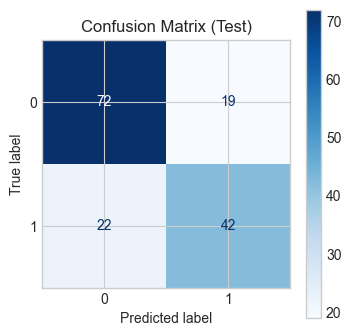

,feature,coef
9,cat__sex_female,1.248879
8,cat__pclass_3,-0.888178
10,cat__sex_male,-0.715529
3,num__fare,0.237482
0,num__age,-0.178987
1,num__sibsp,-0.139923
6,cat__pclass_1,0.069117
4,num__family_size,-0.011727
5,num__is_alone,-0.009323
2,num__parch,0.000000


In [51]:
# Diagnostics: Confusion Matrix and Feature Importance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix
fig, ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix (Test)")
plt.show()

# Feature Importance (Coefficients)
model = best_model.named_steps["model"]
feature_names = best_model.named_steps["prep"].get_feature_names_out()
coefs = pd.DataFrame({
    "feature": feature_names,
    "coef": model.coef_.ravel()
}).sort_values("coef", key=np.abs, ascending=False)
coefs.head(20)


In [52]:
# Save Artifacts

import json
import joblib
from pathlib import Path

# Ensure metrics exist; compute from best_model if needed
try:
    _ = (test_acc, pr, rc, f1, test_auc)
except NameError:
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
    y_test_pred = best_model.predict(X_test)
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    test_acc = accuracy_score(y_test, y_test_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average="binary")
    try:
        test_auc = roc_auc_score(y_test, y_test_proba)
    except Exception:
        test_auc = float("nan")

ARTIFACTS = Path("artifacts")
ARTIFACTS.mkdir(exist_ok=True, parents=True)

joblib.dump(best_model, ARTIFACTS / "model.joblib")

# Save feature names from preprocessing step
feature_names = best_model.named_steps["prep"].get_feature_names_out()
(ARTIFACTS / "feature_names.json").write_text(json.dumps(feature_names.tolist(), indent=2))

# Persist metrics
metrics_payload = {
    "accuracy": float(test_acc),
    "precision": float(pr),
    "recall": float(rc),
    "f1": float(f1),
    "roc_auc": float(test_auc) if str(test_auc) != "nan" else None,
}
(ARTIFACTS / "test_metrics.json").write_text(json.dumps(metrics_payload, indent=2))

print("Saved model and metrics to:", ARTIFACTS.resolve())


Saved model and metrics to: C:\Users\Purnendu Kale\Logistic-Regression-on-titanic-dataset\artifacts


In [53]:
# Inference Example

import json
import joblib
import numpy as np
import pandas as pd

from pathlib import Path

ARTIFACTS = Path("artifacts")
model_path = ARTIFACTS / "model.joblib"
feature_names_path = ARTIFACTS / "feature_names.json"

if model_path.exists() and feature_names_path.exists():
    model = joblib.load(model_path)
    feature_names = json.loads(feature_names_path.read_text())

    # Use a small sample from the original cleaned dataset if available
    try:
        sample = X_test.iloc[:5].copy()
    except Exception:
        # Fallback: construct a minimal sample resembling training schema
        sample = pd.DataFrame([
            {"pclass": 3, "sex": "male", "age": 22.0, "sibsp": 1, "parch": 0, "fare": 7.25, "embarked": "S", "family_size": 2, "is_alone": 0},
            {"pclass": 1, "sex": "female", "age": 38.0, "sibsp": 1, "parch": 0, "fare": 71.28, "embarked": "C", "family_size": 2, "is_alone": 0},
        ])

    preds = model.predict(sample)
    proba = model.predict_proba(sample)[:, 1]
    display(pd.DataFrame({"pred_survived": preds, "prob_survived": proba}))
else:
    print("Model artifacts not found. Run training/tuning and saving cells first.")


,pred_survived,prob_survived
0,1,0.595239
1,0,0.270810
2,1,0.589230
3,0,0.308874
4,0,0.482168
